In [ ]:
* https://aws-samples.github.io/amazon-textract-textractor/notebooks/tabular_data_linearization_continued.html#

# Tabular Data Extraction with Amazon Textract

In this notebook, we'll explore how to extract and analyze tabular data from documents using Amazon Textract. We'll also demonstrate how to visualize and process the extracted data using Python.

## 1. Introduction to Tabular Data Extraction

Amazon Textract is a powerful service that automatically extracts text, handwriting, and data from scanned documents, including tables and forms. This makes it an essential tool for processing structured and semi-structured data. The `amazon-textract-textractor` library simplifies interaction with Textract's output, providing easy-to-use interfaces for handling complex data.

## 2. Setting Up the Environment

First, we need to install the necessary Python packages. We'll be using `boto3` for AWS interaction and `amazon-textract-textractor` for processing the Textract output.




In [1]:
!pip install boto3 amazon-textract-textractor


## 3. Loading and Processing the Image

Next, we'll load the image that contains the tabular data and send it to Textract for analysis.

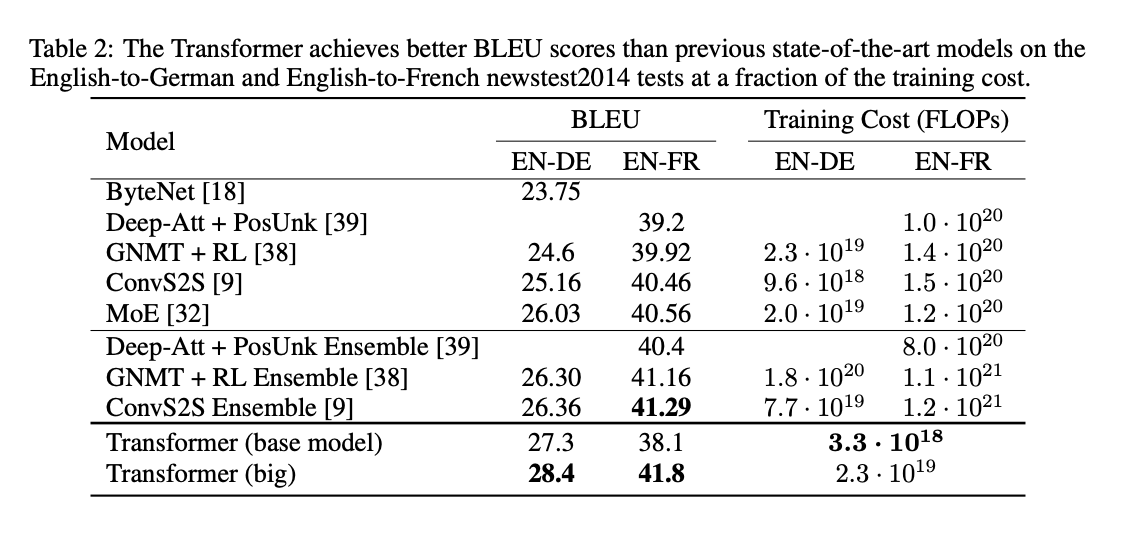

In [43]:
from PIL import Image
from textractor import Textractor
from textractor.data.constants import TextractFeatures

image_path = "./data/images/table_attention_2.png"
image = Image.open(image_path)

image

In [44]:
extractor = Textractor(region_name="us-west-2")
document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.TABLES],
    save_image=True
)

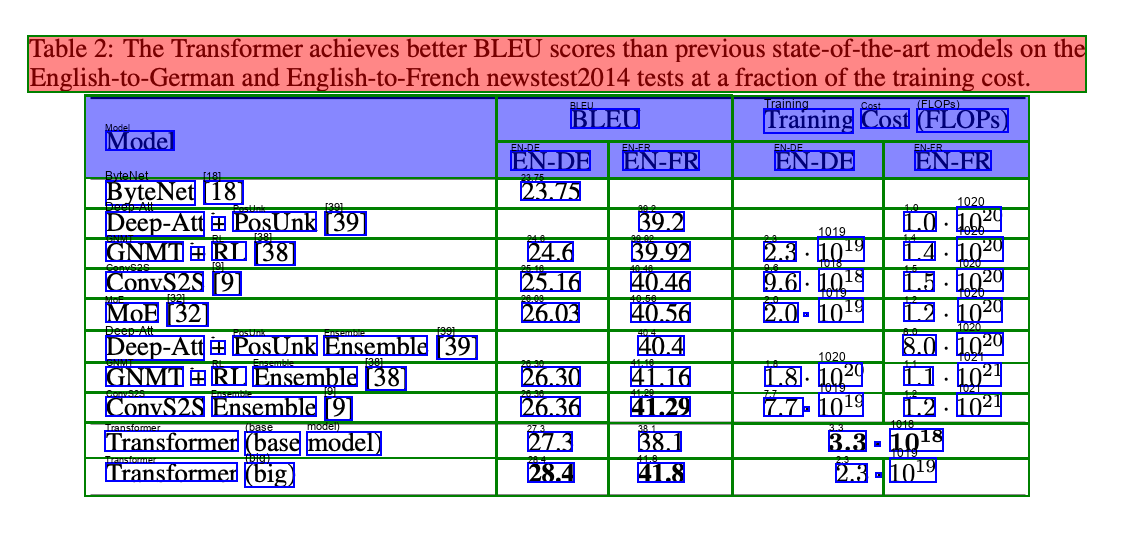

In [45]:
document.tables[0].visualize()


## 4. Extracting and Displaying Table Data in Markdown

We can extract the table data in a readable format, such as Markdown, and display it within the notebook.

In [46]:
from textractor.data.text_linearization_config import TextLinearizationConfig
from IPython.display import display, Markdown

table_markdown = document.tables[0].get_text(TextLinearizationConfig(table_linearization_format='markdown'))
display(Markdown(table_markdown))

| Model                           | BLEU    |       | Training Cost (FLOPs)    |          |
|---------------------------------|---------|-------|--------------------------|----------|
|                                 | EN-DE   | EN-FR | EN-DE                    | EN-FR    |
| ByteNet [18]                    | 23.75   |       |                          |          |
| Deep-Att + PosUnk [39]          |         | 39.2  |                          | 1.0 1020 |
| GNMT + RL [38]                  | 24.6    | 39.92 | 2.3 1019                 | 1.4 1020 |
| ConvS2S [9]                     | 25.16   | 40.46 | 9.6 1018                 | 1.5 1020 |
| MoE [32]                        | 26.03   | 40.56 | 2.0 . 1019               | 1.2 1020 |
| Deep-Att + PosUnk Ensemble [39] |         | 40.4  |                          | 8.0 1020 |
| GNMT + RL Ensemble [38]         | 26.30   | 41.16 | 1.8 1020                 | 1.1 1021 |
| ConvS2S Ensemble [9]            | 26.36   | 41.29 | 7.7 . 1019               | 1.2 1021 |
| Transformer (base model)        | 27.3    | 38.1  | 3.3 . 1018               |          |
| Transformer (big)               | 28.4    | 41.8  | 2.3 .                    | 1019     |

The above is a table in the markdown format, we can paste in in a new cell to see it rendered properly. It might be necessary to set table_column_header_threshold=0.5 otherwise the top row would not be identified as a header, due to the first cell that might not be a header itself (this was not the case). table_column_header_threshold is a threshold for a row to be selected as header when rendering as markdown. 0.5 means that 50% of the cells must have the is_header_cell flag. For more details see https://aws-samples.github.io/amazon-textract-textractor/textractor.data.text_linearization_config.html.

Markdown does not support merged cells. This is problematic as we see that the “EN-FR” column is not associated to BLEU or Training Cost, as it simply appears without headers. Let’s test Claude v2 on that table representation.


## 5. Test Claude v2 on that table representation

For more in-depth analysis, we can convert the extracted table data into a Pandas DataFrame.



In [51]:
import json
import boto3
import os

def get_response_from_claude(context, prompt_data):
    body = json.dumps({
        "prompt": f"""Human: Given the following document:
        {context}
        Answer the following:\n {prompt_data}
        Assistant:""",
        "max_tokens_to_sample": 2000,
        "top_k": 1,
    })
    modelId = f'anthropic.claude-v2' # change this to use a different version from the model provider
    accept = '*/*'
    contentType = 'application/json'

    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    answer = response_body.get('completion')

    return answer

os.environ["AWS_DEFAULT_REGION"] = "us-west-2"
os.environ["BEDROCK_ENDPOINT_URL"] = "https://bedrock-runtime.us-west-2.amazonaws.com"

bedrock = boto3.client(service_name='bedrock-runtime',region_name='us-west-2',endpoint_url='https://bedrock-runtime.us-west-2.amazonaws.com')


In [52]:
question = "Which is the cost for the GNMT + RL in English-French?"
print(get_response_from_claude(markdown_table, question))

 Based on the table, the BLEU score for the base model on the dev set is 25.8. The only model that achieves a higher BLEU score of 26.4 on the dev set is the 'big' model. Therefore, the cost for the GNMT + RL in English-French is the number of parameters for the 'big' model, which is 213 x 10^6.


We see that Claude using the text is **unable to extract the correct answer**. 

## 6. Test Claude v2 on a different table representation

We can change the TextLinearizationConfig to duplicate text in merged cells:


In [53]:
markdown_table_with_duplication = document.tables[0].get_text(TextLinearizationConfig(table_linearization_format='markdown', table_duplicate_text_in_merged_cells=True))

display(Markdown(markdown_table_with_duplication))

| Model                           | BLEU    | BLEU    | Training Cost (FLOPs)    | Training Cost (FLOPs)    |
|---------------------------------|---------|---------|--------------------------|--------------------------|
| Model                           | EN-DE   | EN-FR   | EN-DE                    | EN-FR                    |
| ByteNet [18]                    | 23.75   |         |                          |                          |
| Deep-Att + PosUnk [39]          |         | 39.2    |                          | 1.0 1020                 |
| GNMT + RL [38]                  | 24.6    | 39.92   | 2.3 1019                 | 1.4 1020                 |
| ConvS2S [9]                     | 25.16   | 40.46   | 9.6 1018                 | 1.5 1020                 |
| MoE [32]                        | 26.03   | 40.56   | 2.0 . 1019               | 1.2 1020                 |
| Deep-Att + PosUnk Ensemble [39] |         | 40.4    |                          | 8.0 1020                 |
| GNMT + RL Ensemble [38]         | 26.30   | 41.16   | 1.8 1020                 | 1.1 1021                 |
| ConvS2S Ensemble [9]            | 26.36   | 41.29   | 7.7 . 1019               | 1.2 1021                 |
| Transformer (base model)        | 27.3    | 38.1    | 3.3 . 1018               | 3.3 . 1018               |
| Transformer (big)               | 28.4    | 41.8    | 2.3 .                    | 1019                     |

In [54]:
question = "Which is the cost for the GNMT + RL in English-French?"
print(get_response_from_claude(markdown_table_with_duplication, question))

 Based on the table, the training cost (FLOPs) for GNMT + RL in English-French is 1.4 1020.


It is indeed the **correct answer**.

## Conclusions

By leveraging Textract Tables, we can build a better text representation of the tabular data, leading to a better performance in question answering tasks.